In [1]:
%pylab inline
%gui qt

Populating the interactive namespace from numpy and matplotlib


### Load Sorted Data

In [2]:
from spiketag.mvc import Sorter

In [3]:
app = Sorter('/mnt/ramdisk/pcie.bin', '/mnt/ramdisk/pcie_spktag.bin')

[INFO/MainProcess] load mua data


#############  load data  ###################
/mnt/ramdisk/pcie.bin loaded, it contains: 
30150587 * 32 points (3859275136 bytes) 
32 channels with sampling rate of 25000.0000 
1206.023 secs (20.100 mins) of data
#############################################


[INFO/MainProcess] load spktag file


In [4]:
app.run()

In [5]:
app.vq['labels'][26]

array([1, 0, 3, 2, 1, 0, 3, 3, 1, 0, 0, 3, 2, 3, 3, 1, 2, 1, 3, 0, 3, 1, 2,
       1, 2, 2, 1, 0, 3, 0, 2, 2, 1, 3, 2, 1, 1, 3, 3, 0, 0, 3, 0, 1, 2, 2,
       1, 0, 3, 2, 3, 3, 2, 1, 2, 3, 0, 1, 0, 3, 2, 0, 0, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 2, 1, 1, 3, 1, 1, 2, 0, 3, 1, 2, 1, 0, 2, 3, 1, 1,
       3, 3, 2, 0, 3, 3, 3, 2])

In [6]:
app.vq['points'][26]

array([[  4.16119662e-03,   1.42117989e-04,  -1.11736284e-02],
       [ -4.76963778e-01,   5.25984678e-02,  -2.45644263e-02],
       [  1.23210976e-01,  -1.04865550e-02,  -1.01957544e-02],
       [  4.01460445e-02,   1.19649370e-01,   1.56332700e-02],
       [ -8.92058826e-02,  -2.94222620e-02,   1.12136198e-02],
       [ -3.55025090e-01,  -1.49841649e-02,  -4.71683426e-02],
       [  8.19082931e-02,  -2.47851726e-02,  -3.18782755e-02],
       [  7.74687407e-02,   9.56536012e-03,   3.28124760e-02],
       [ -1.41607717e-01,  -5.05188119e-02,   3.09714684e-02],
       [ -3.19158783e-01,   3.58684021e-02,  -3.17317321e-02],
       [ -5.05066071e-01,  -1.85973287e-02,  -1.63912738e-02],
       [  4.96160423e-02,  -2.91375093e-02,  -7.14798105e-03],
       [  4.29651243e-02,   6.06316279e-02,  -4.67750075e-03],
       [  1.09359570e-01,  -2.67798036e-03,  -2.13831041e-02],
       [  1.37921324e-01,  -2.36169878e-02,  -3.63421530e-02],
       [ -1.33395741e-01,  -3.09101031e-03,   4.3087823

In [7]:
app.vq['scores'][26]

0.99044978434996922

In [23]:
app.model.spktag.spktag['t'].shape

(314904,)

In [26]:
app.model.spktag.spktag['clu'].shape

(314904,)

### Learn a new linear projection: LDA

In [5]:
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [261]:
X = app.fet
y = app.clu.membership

In [13]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
lda.fit(X,y)

LinearDiscriminantAnalysis(n_components=3, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [14]:
newfet = np.dot(X, lda.scalings_)

In [66]:
newfet = np.dot(newfet, np.linalg.inv(lda.scalings_))

In [15]:
newfet = newfet/-newfet.min()

In [16]:
app.fet = newfet

In [10]:
correct_labels = y

In [52]:
labels = lda.predict(X)

In [11]:
lda.score(X, correct_labels)

0.99121996303142335

In [165]:
from sklearn.decomposition import FastICA, PCA

In [166]:
spk = app.spk

In [167]:
X = spk.transpose(0,2,1).ravel().reshape(-1, spk.shape[1]*spk.shape[2])
X.shape

(25524, 75)

In [169]:
ica = FastICA(n_components=3, whiten=True)
S_ = ica.fit_transform(X)  # Reconstruct signals

clustering method: hdbscan, chNo: 25, fall_off_size: 19


In [160]:
S_ = S_/S_.min()

In [161]:
app.fet = S_

clustering method: hdbscan, chNo: 25, fall_off_size: 19


###### K-Means Tree

In [217]:
from sklearn.cluster import KMeans

In [300]:
X = app.fet
y = app.clu.membership

In [333]:
km = KMeans(500)

In [334]:
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=500, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [323]:
_X = np.vstack((km.cluster_centers_, X))

In [324]:
_X[99]

array([-0.44416327, -0.0174318 , -0.01818248])

In [5]:
from spiketag.view import scatter_3d_view

In [306]:
sdview = scatter_3d_view()
sdview.set_data(_X, clu=np.ones(len(_X)).astype(np.int64))

In [307]:
sdview.show()

In [310]:
sdview.highlight(np.arange(50))

In [335]:
app.model.construct_kdtree(app.ch)

In [336]:
d = []
for _kd in app.model.kd:
    tmp = _kd.query(km.cluster_centers_, 10)[0]
    d.append(tmp.mean(axis=1))
d = np.vstack(np.asarray(d))

In [337]:
labels = np.argmin(d,axis=0)

In [343]:
labels

array([0, 3, 1, 2, 0, 1, 3, 0, 2, 2, 0, 3, 0, 3, 2, 1, 3, 0, 1, 1, 1, 3, 2,
       1, 3, 0, 1, 1, 3, 0, 0, 3, 1, 1, 2, 2, 3, 0, 2, 2, 0, 0, 3, 1, 2, 3,
       3, 2, 1, 0, 1, 3, 2, 3, 1, 0, 1, 0, 1, 1, 3, 0, 2, 1, 0, 1, 2, 2, 3,
       2, 3, 3, 1, 3, 1, 0, 3, 0, 0, 2, 3, 1, 2, 0, 3, 3, 2, 2, 3, 1, 1, 2,
       2, 1, 0, 3, 3, 3, 0, 3, 2, 0, 1, 0, 1, 3, 1, 1, 3, 3, 2, 2, 3, 0, 1,
       2, 3, 3, 3, 3, 1, 0, 3, 2, 1, 1, 2, 1, 3, 0, 0, 3, 3, 1, 1, 2, 3, 1,
       2, 1, 0, 1, 0, 3, 3, 3, 0, 2, 0, 0, 3, 3, 1, 3, 3, 1, 3, 2, 1, 1, 3,
       0, 1, 0, 1, 3, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 3, 0, 3, 1, 0, 2, 1, 1,
       1, 0, 1, 2, 2, 0, 2, 0, 3, 1, 1, 1, 3, 1, 3, 3, 0, 0, 1, 1, 2, 0, 1,
       1, 2, 3, 3, 1, 1, 3, 2, 0, 3, 1, 3, 2, 3, 2, 2, 2, 1, 2, 1, 0, 3, 2,
       0, 2, 3, 0, 1, 2, 0, 3, 3, 3, 3, 0, 3, 3, 2, 1, 3, 2, 1, 3, 0, 2, 1,
       0, 3, 2, 2, 0, 1, 1, 1, 2, 3, 1, 2, 1, 0, 3, 3, 0, 3, 2, 0, 1, 0, 2,
       0, 3, 1, 0, 1, 2, 2, 3, 3, 1, 1, 0, 3, 0, 3, 1, 2, 0, 3, 3, 2, 3, 3,
       1, 1,

In [339]:
from spiketag.base import CLU
sdview = scatter_3d_view()
sdview.set_data(km.cluster_centers_, clu=CLU(labels))

In [340]:
sdview.show()

In [341]:
k = 1
knn = KNN(n_neighbors=k)
knn.fit(km.cluster_centers_, labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [342]:
knn.score(X,y)

0.99376155268022182

In [355]:
labels[km.predict(X)]

array([3, 0, 3, ..., 1, 3, 1])

In [354]:
knn.predict(X)

array([3, 0, 3, ..., 1, 3, 1])

## Classification
### cross-validation

In [94]:
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import KFold

In [95]:
spk = app.spk
X = spk.transpose(0,2,1).ravel().reshape(-1, spk.shape[1]*spk.shape[2])
y = app.clu.membership

In [125]:
X = app.fet
y = app.clu.membership

In [126]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.9, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4464, 3), (4464,), (40179, 3), (40179,))

#### 1. LDA

In [127]:
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [150]:
scores = []
kf = KFold(len(y), n_folds=10, shuffle=False, random_state=None)
for train, test in kf:
    X_train = X[train,:]
    y_train = y[train]
    X_test  = X[test,:]
    y_test  = y[test]
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
    lda.fit(X_train, y_train)
    scores.append(lda.score(X_test, y_test))
scores = np.asarray(scores)

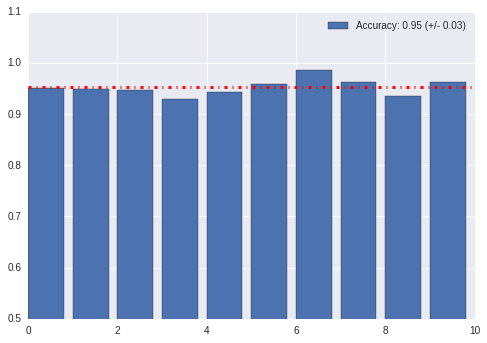

In [151]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

In [129]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_train, y_train)
lda.score(X_test, y_test)

0.96258960573476704

In [130]:
k_folds = 10
scores = cross_validation.cross_val_score(lda, X, y, cv=k_folds, verbose=1)
scores

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([ 0.9218715 ,  0.95254086,  0.95789474,  0.96303763,  0.96684588,
        0.96886201,  0.97042348,  0.96930316,  0.95272238,  0.90701322])

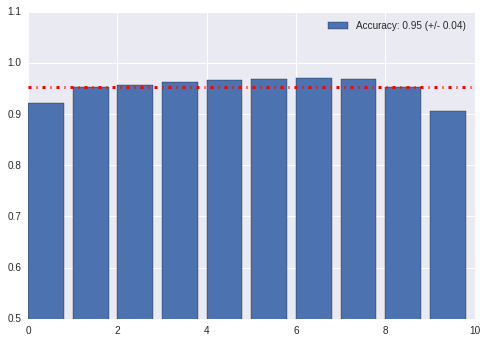

In [131]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

#### 2. SVM

In [152]:
from sklearn.svm import SVC as SVM

In [153]:
svm = SVM(kernel='linear', C=3)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.96852862942741147

In [ ]:
k_folds = 10
scores = cross_validation.cross_val_score(svm, X, y, cv=k_folds)
scores

In [ ]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

#### 3. KNN

In [132]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [133]:
k = 1
knn = KNN(n_neighbors=k, algorithm='kd_tree')

In [134]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.97939068100358428

In [139]:
k_folds = 10
scores = cross_validation.cross_val_score(knn, X, y, cv=k_folds)
scores

array([ 0.97134542,  0.99082158,  0.99417693,  0.99417563,  0.99484767,
        0.99619176,  0.99596684,  0.9968631 ,  0.99484652,  0.97400851])

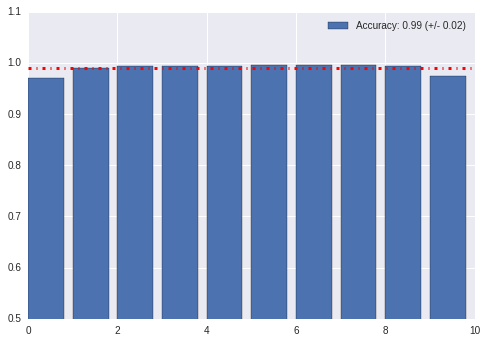

In [140]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

#### 4. K-Means

A vector-quantization based classifier

In [141]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier as KNN

In [142]:
km = MiniBatchKMeans(100)
k_folds = 10

In [143]:
def _predict(km):
    app.model.construct_kdtree(app.ch)
    d = []
    for _kd in app.model.kd:
        tmp = _kd.query(km.cluster_centers_, 10)[0]
        d.append(tmp.mean(axis=1))
    d = np.vstack(np.asarray(d))
    labels = np.argmin(d,axis=0)
    return labels

In [154]:
scores = []
kf = KFold(len(y), n_folds=k_folds, shuffle=True, random_state=None)
for train, test in kf:
    X_train = X[train,:]
    y_train = y[train]
    X_test  = X[test,:]
    y_test  = y[test]
    km.fit(X_train)
    points = km.cluster_centers_
    labels = app._predict(points)
    knn = KNN(n_neighbors=1)
    knn.fit(km.cluster_centers_, labels)
    scores.append(knn.score(X_test, y_test))
scores = np.asarray(scores)

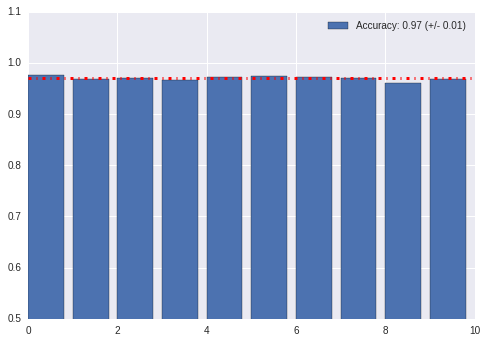

In [155]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

In [152]:
scores = []
kf = KFold(len(y), n_folds=k_folds, shuffle=False)
for train, test in kf:
    X_train = X[train,:]
    y_train = y[train]
    X_test  = X[test,:]
    y_test  = y[test]
    km.fit(X_train, y_train)
    labels = _predict(km)
    knn = KNN(n_neighbors=1)
    knn.fit(km.cluster_centers_, labels)
    scores.append(knn.score(X_test, y_test))
scores = np.asarray(scores)

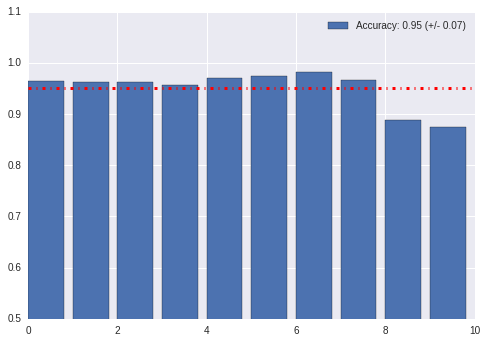

In [153]:
_ac_l = "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
plt.bar(np.arange(k_folds), scores, label=_ac_l)
plt.axhline(scores.mean(),ls='-.', lw=3 ,c='r')
ylim(0.5,1.1)
legend(loc='best')

In [119]:
scores

array([ 0.98922248,  0.98460354,  0.98075443,  0.99153195,  0.98767334,
        0.99460709,  0.99152542,  0.99383667,  0.97919877,  0.9807396 ])